## 1. Persiapan Data

### 1.1. Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

### 1.2. Authorization

In [ ]:
from google.colab import files
files.upload()

{}

### 1.3. Download Dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d itachi9604/disease-symptom-description-dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


### 1.4. Unzip Dataset

In [ ]:
with ZipFile('disease-symptom-description-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')


### 1.5. Load Dataset

In [ ]:
# Dataset utama (gejala dan label penyakit)
df_main = pd.read_csv('dataset/dataset.csv')

# Dataset pendukung
df_severity = pd.read_csv('dataset/Symptom-severity.csv')
df_description = pd.read_csv('dataset/symptom_Description.csv')
df_precaution = pd.read_csv('dataset/symptom_precaution.csv')


## 2. Exploratory Data Analysis (EDA)

###  2.1. Cek Struktur dan Ringkasan Data

In [ ]:
print(df_main.shape)
print(df_main.info())
print(df_main.head())


(4920, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB
None
            Disease   Symptom_1   

### 2.2. Cek Missing Value

In [ ]:
df_main.isnull().sum()


,0
Disease,0
Symptom_1,0
Symptom_2,0
Symptom_3,0
Symptom_4,348
Symptom_5,1206
Symptom_6,1986
Symptom_7,2652
Symptom_8,2976
Symptom_9,3228


### 2.3. Distribusi Penyakit

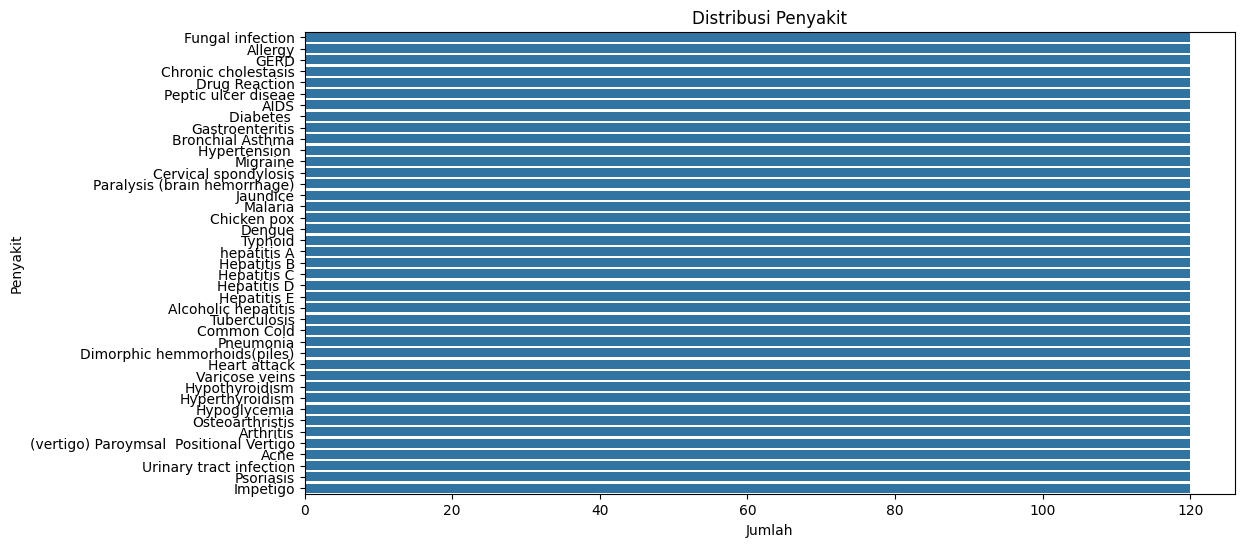

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(y='Disease', data=df_main, order=df_main['Disease'].value_counts().index)
plt.title("Distribusi Penyakit")
plt.xlabel("Jumlah")
plt.ylabel("Penyakit")
plt.show()


### 2.4. Jumlah Gejala Tiap Kasus

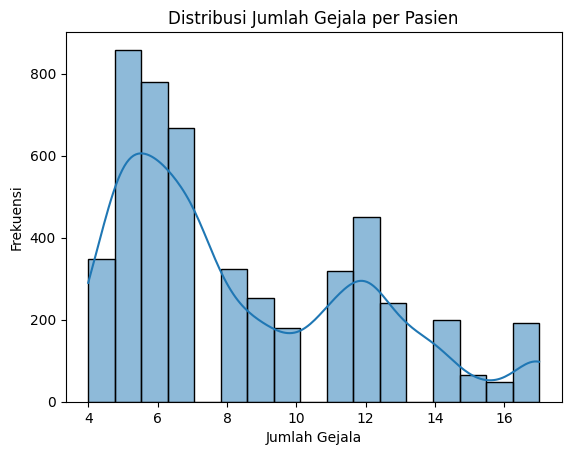

In [ ]:
def count_symptoms(row):
    return row.notnull().sum()

df_main['num_symptoms'] = df_main.iloc[:, :-1].apply(count_symptoms, axis=1)

sns.histplot(df_main['num_symptoms'], bins=17, kde=True)
plt.title("Distribusi Jumlah Gejala per Pasien")
plt.xlabel("Jumlah Gejala")
plt.ylabel("Frekuensi")
plt.show()


## 3. Data Preprocessing

### 3.1. Menangani Missing Value

In [ ]:
# Isi missing value dengan 'none' dan ubah jadi lowercase
symptom_cols = [col for col in df_main.columns if "Symptom_" in col]
for col in symptom_cols:
    df_main[col] = df_main[col].fillna('none').str.strip().str.lower()


### 3.2. Normalisasi Nama Gejala

In [ ]:
for col in symptom_cols:
    df_main[col] = df_main[col].str.replace('_', ' ').str.strip().str.lower()

### 3.3. Gabungkan dengan Severity Score

In [ ]:
# Load data severity
severity_map = dict(zip(df_severity['Symptom'].str.lower().str.strip(), df_severity['weight']))

# Ubah symptom menjadi skor numerik
def encode_symptom(symptom):
    return severity_map.get(symptom, 0)

# Terapkan ke semua kolom symptom
for col in symptom_cols:
    df_main[col] = df_main[col].apply(encode_symptom)


### 3.4. Encoding Label Target

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_main['Disease'] = le.fit_transform(df_main['Disease'])


### 3.5. Pemisahan Fitur dan Label

In [ ]:
X = df_main[symptom_cols]
y = df_main['Disease']


### 3.6. Split Data untuk Pelatihan dan Pengujian

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
